In [3]:
import pickle
import numpy as np
from skimage import io
import pandas as pd

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path
import math

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF

from matplotlib import colors, pyplot as plt
%matplotlib inline

import torch
import torchvision
from torch.optim import lr_scheduler
from torchvision.io import read_image

from skimage.io import imread
from skimage.transform import resize
import os

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Загружаем данные из датасета (использовали [CelebA](https://colab.research.google.com/corgiredirector?site=https%3A%2F%2Fmmlab.ie.cuhk.edu.hk%2Fprojects%2FCelebA.html)).





In [6]:
!pip install -q gdown
!gdown "https://drive.google.com/uc?id=1ua-4-Ht4-0JwtjwzeaIbuYGaSHIIapg0" -O celebA_train_500.zip
!unzip -q celebA_train_500.zip && rm celebA_train_500.zip

Downloading...
From (original): https://drive.google.com/uc?id=1ua-4-Ht4-0JwtjwzeaIbuYGaSHIIapg0
From (redirected): https://drive.google.com/uc?id=1ua-4-Ht4-0JwtjwzeaIbuYGaSHIIapg0&confirm=t&uuid=58ba0af2-f6ff-4d34-ade3-b8385feac10d
To: /content/celebA_train_500.zip
100% 170M/170M [00:01<00:00, 166MB/s]
replace celebA_train_500/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: А
error:  invalid response [А]
replace celebA_train_500/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [5]:
!ls celebA_train_500

celebA_anno.txt  celebA_imgs  celebA_train_split.txt


In [6]:
anno = {}
with open('celebA_train_500/celebA_anno.txt') as file:
    for line in file:
        key, value = line.split()
        anno[key] = int(value)

In [7]:
sp = {}
with open('celebA_train_500/celebA_train_split.txt') as file:
    for line in file:
        key, value = line.split()
        sp[key] = int(value)

In [8]:
train_labels = {}
val_labels = {}
test_labels = {}
root = 'celebA_train_500/celebA_imgs'
files = list(os.walk(os.path.join(root)))[0][2]
for i in range(len(files)):
    if files[i] in anno:
        if sp[files[i]] == 0:
            train_labels[files[i]] = anno[files[i]]
        if sp[files[i]] == 1:
            val_labels[files[i]] = anno[files[i]]
        if sp[files[i]] == 2:
            test_labels[files[i]] = anno[files[i]]

train_labels = pd.DataFrame(list(train_labels.items()), columns = ['img', 'label'])
val_labels = pd.DataFrame(list(val_labels.items()), columns = ['img', 'label'])
test_labels = pd.DataFrame(list(test_labels.items()), columns = ['img', 'label'])
train_labels.head()

,img,label
0,115915.jpg,495
1,018349.jpg,459
2,023405.jpg,261
3,083588.jpg,3
4,000137.jpg,134


In [9]:
class FaceDataset(Dataset):
    def __init__(self, labels : pd.DataFrame, img_dir, transform=None):
        self.img_labels = labels
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = np.array(Image.open(img_path))
        image = Image.fromarray(image[77:-41, 45:-50])
        label = int(self.img_labels.iloc[idx, 1])
        if self.transform:
            image = self.transform(image)
        return image, label

In [10]:
transform_base = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((224, 224), antialias=True),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

train_dataset = FaceDataset(train_labels, root, transform_base)
val_dataset = FaceDataset(val_labels, root, transform_base)
test_dataset = FaceDataset(test_labels, root, transform_base)

In [11]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.title(title)
    plt_ax.grid(False)

In [13]:
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
print(len(train_loader), len(val_loader), len(test_loader))

134 30 25


# **Дообучения clip**

In [20]:
import clip
print(clip.available_models())
clip_model, preprocess = clip.load("ViT-B/32", device=device)

['RN50', 'RN101', 'RN50x4', 'RN50x16', 'RN50x64', 'ViT-B/32', 'ViT-B/16', 'ViT-L/14', 'ViT-L/14@336px']


In [21]:
# clip_model.visual

In [22]:
for name, child in clip_model.named_children():
    print(name)

visual
transformer
token_embedding
ln_final


In [23]:
class CLIPforFACE(nn.Module):
    def __init__(self, clip_model, num_classes=500, unfreeze_last_n=4):
        super().__init__()
        self.visual = clip_model.visual
        self.classifier = nn.Linear(512, num_classes)

        total_layers = len(self.visual.transformer.resblocks)
        print(f"Всего слоев в ViT: {total_layers}, размораживаем последние {unfreeze_last_n}")

        for name, param in self.visual.named_parameters():
            layer_found = False
            for i in range(total_layers):
                if f"transformer.resblocks.{i}." in name:
                    if i >= total_layers - unfreeze_last_n:
                        param.requires_grad_(True)
                    else:
                        param.requires_grad_(False)
                    layer_found = True
                    break

            if not layer_found:
                param.requires_grad_(False)

    def forward(self, x):
        with torch.autocast(device_type='cuda', dtype=torch.float16):
            features = self.visual(x)
        return self.classifier(features.float())

    def get_embeddings(self, x):
        with torch.no_grad():
            with torch.autocast(device_type='cuda', dtype=torch.float16):
                features = self.visual(x)
        return features.float()

In [24]:
model = CLIPforFACE(clip_model).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=1e-4)
loaders = {"train": train_loader, "val": val_loader}

Всего слоев в ViT: 12, размораживаем последние 4


In [ ]:
def train_loop(model, optimizer, criterion, loaders, max_epochs, scheduler=None, use_arcface=False):
    accuracy = {"train": [], "val": []}
    history = {'epoch': [],
               'train': [], 'val': []}

    train_loader = loaders['train']
    val_loader = loaders['val']

    for epoch in range(max_epochs):
        train_correct, train_all, train_loss = 0, 0, 0
        val_correct, val_all, val_loss = 0, 0, 0
        for x_batch, y_batch in train_loader:
            model.train()

            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            outp = model(x_batch)
            loss = criterion(outp, y_batch)
            loss.backward()
            optimizer.step()

            # calc accuracy
            preds = outp.argmax(-1)
            correct =  torch.sum(y_batch == preds)
            all = len(y_batch)
            train_correct += correct.item()
            train_all += all

            train_loss += loss.item()


        history['train'].append(train_loss/len(train_loader))
        history['epoch'].append(epoch)
        accuracy['train'].append(train_correct/train_all)

        for x_batch, y_batch in val_loader:
            model.eval()

            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            with torch.no_grad():
                outp = model(x_batch)
                loss = criterion(outp, y_batch)


            preds = outp.argmax(-1)
            correct =  torch.sum(y_batch == preds)
            all = len(y_batch)
            val_correct += correct.item()
            val_all += all

            val_loss += loss.item()

        history['val'].append(val_loss/len(val_loader))
        accuracy['val'].append(val_correct/val_all)


        train_loss = history['train'][-1]
        val_loss = history['val'][-1]
        train_acc = accuracy['train'][-1]
        val_acc = accuracy['val'][-1]

        print(f"Epoch: {epoch+1}, Train acc: {train_acc:.4f}, loss: {train_loss:.4f}, Val acc: {val_acc:.4f}, loss: {val_loss:.4f}")

        if scheduler:
            scheduler.step()

    return model, accuracy, history


In [ ]:
def plot_history(history, acc):
    fig1, axes1 = plt.subplots(nrows=1, ncols=2)

    axes1[0].plot(history['epoch'], history['train'], label='train_loss')
    axes1[0].plot(history['epoch'], history['val'], label='val_loss')
    axes1[0].grid()
    axes1[0].legend()

    axes1[1].plot(history['epoch'], acc['train'], label='train_accuracy')
    axes1[1].plot(history['epoch'], acc['val'], label='val_accuracy')
    axes1[1].grid()
    axes1[1].legend()

In [ ]:
max_epochs = 25
trained_model, acc, hist = train_loop(model, optimizer, criterion, loaders, max_epochs)

Epoch: 1, Train acc: 0.0098, loss: 6.1441, Val acc: 0.0277, loss: 6.0051
Epoch: 2, Train acc: 0.0754, loss: 5.8937, Val acc: 0.1225, loss: 5.7834
Epoch: 3, Train acc: 0.1964, loss: 5.6686, Val acc: 0.2316, loss: 5.5765
Epoch: 4, Train acc: 0.3264, loss: 5.4558, Val acc: 0.3546, loss: 5.3803
Epoch: 5, Train acc: 0.4265, loss: 5.2511, Val acc: 0.4255, loss: 5.1923
Epoch: 6, Train acc: 0.4944, loss: 5.0551, Val acc: 0.4760, loss: 5.0117
Epoch: 7, Train acc: 0.5568, loss: 4.8637, Val acc: 0.5154, loss: 4.8377
Epoch: 8, Train acc: 0.5899, loss: 4.6809, Val acc: 0.5373, loss: 4.6695
Epoch: 9, Train acc: 0.6250, loss: 4.5041, Val acc: 0.5575, loss: 4.5082
Epoch: 10, Train acc: 0.6470, loss: 4.3338, Val acc: 0.5809, loss: 4.3528
Epoch: 11, Train acc: 0.6722, loss: 4.1691, Val acc: 0.5969, loss: 4.2034
Epoch: 12, Train acc: 0.6914, loss: 4.0111, Val acc: 0.6145, loss: 4.0601
Epoch: 13, Train acc: 0.7088, loss: 3.8582, Val acc: 0.6283, loss: 3.9228
Epoch: 14, Train acc: 0.7190, loss: 3.7129, Val

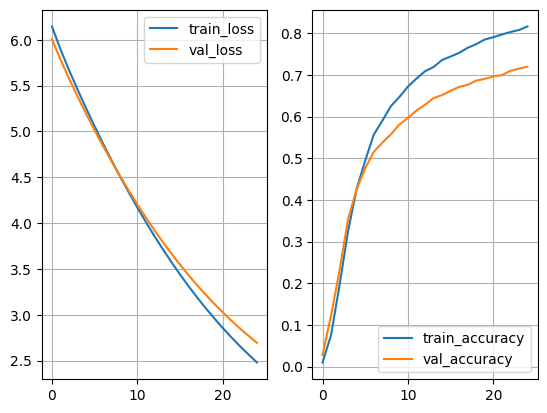

In [ ]:
plot_history(hist, acc)

In [ ]:
def save_model(model, path='clip_face_model.pth'):
    torch.save({
        'model_state_dict': model.state_dict(),
        'num_classes': model.classifier.out_features,
        'unfreeze_last_n': 4 
    }, path)
    print(f"Модель сохранена в {path}")

save_model(trained_model)

Модель сохранена в clip_face_model.pth


# **Тестируем**

In [26]:
def load_model(clip_model, path='clip_face_model.pth'):
    if not os.path.exists(path):
        raise FileNotFoundError(f"Файл модели {path} не найден")

    checkpoint = torch.load(path)

    model = CLIPforFACE(
        clip_model,
        num_classes=checkpoint['num_classes'],
        unfreeze_last_n=checkpoint['unfreeze_last_n']
    ).to(device)

    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"Модель загружена из {path}")
    return model

In [27]:
loaded_model = load_model(clip_model)

Всего слоев в ViT: 12, размораживаем последние 4
Модель загружена из clip_face_model.pth


In [28]:
from sklearn.neighbors import NearestNeighbors

def test_model(model, test_loader, num_classes=500, k_samples=5, k_others=10):
    model.eval()

    all_embeddings = []
    all_labels = []
    all_images = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            embeddings = model.get_embeddings(images)
            all_embeddings.append(embeddings.cpu().numpy())
            all_labels.append(labels.numpy())
            all_images.append(images.cpu())

    all_embeddings = np.concatenate(all_embeddings)
    all_labels = np.concatenate(all_labels)
    all_images = torch.cat(all_images)

    unique_classes, class_counts = np.unique(all_labels, return_counts=True)

    valid_classes = unique_classes[class_counts >= (k_samples + 1)]

    if len(valid_classes) == 0:
        print(f"Ошибка: Нет классов с минимум {k_samples+1} изображениями")
        return

    test_class = np.random.choice(valid_classes)
    class_indices = np.where(all_labels == test_class)[0]
    other_indices = np.where(all_labels != test_class)[0]

    print(f"Выбран класс {test_class} с {len(class_indices)} изображениями")

    if len(other_indices) < k_others:
        print(f"Предупреждение: Только {len(other_indices)} изображений других классов (запрошено {k_others})")
        k_others = len(other_indices)

    np.random.shuffle(class_indices)
    query_idx = class_indices[0]
    positive_idxs = class_indices[1:k_samples+1]

    np.random.shuffle(other_indices)
    negative_idxs = other_indices[:k_others]

    test_idxs = np.concatenate([[query_idx], positive_idxs, negative_idxs])
    test_embeddings = all_embeddings[test_idxs]
    test_labels = all_labels[test_idxs]

    knn = NearestNeighbors(n_neighbors=len(test_idxs), metric='cosine')
    knn.fit(test_embeddings)
    distances, indices = knn.kneighbors([test_embeddings[0]])
    print(indices)
    print(indices[0])

    plot_results(all_images[test_idxs], test_labels, indices[0], indices[0][0], k_samples)

    return {
        'query_class': test_class,
        'query_idx': query_idx,
        'top5_distances': distances[0][1:6].tolist()
    }

def plot_results(images, labels, indices, query_idx, k_samples=5, num_to_plot = 10):
    plt.figure(figsize=(15, 5))
    k = k_samples + 1

    plt.subplot(1, num_to_plot, 1)
    print(len(images), query_idx)
    imshow(images[query_idx], f"Query (Class {labels[query_idx]})")

    for i, idx in enumerate(indices[1:num_to_plot]):
        plt.subplot(1, num_to_plot, i+2)
        match = "✓" if labels[idx] == labels[query_idx] else "✗"
        imshow(images[idx], f"{i+1}. {match} Class {labels[idx]}")

    plt.tight_layout()
    plt.show()

    correct = sum(labels[idx] == labels[query_idx] for idx in indices[1:k])
    print(f"Точность в топ-{k_samples}: {correct}/{k_samples} ({correct/k_samples:.0%})")

Выбран класс 454 с 4 изображениями
[[ 0  1  3  9 13 10  4 11  2  6 12  5  8  7]]
[ 0  1  3  9 13 10  4 11  2  6 12  5  8  7]
14 0


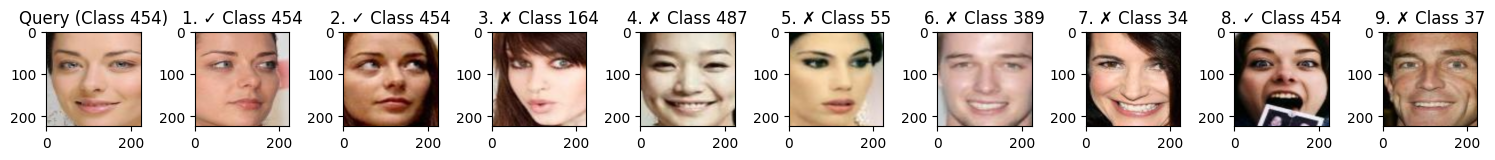

Точность в топ-3: 2/3 (67%)

Детали теста:
Query class: 454
Distances: [0.07880747318267822, 0.12894099950790405, 0.15542328357696533, 0.1608729362487793, 0.18648672103881836]

Выбран класс 336 с 4 изображениями
[[ 0  1  3  2  8  7  6 10 13  5  4 11 12  9]]
[ 0  1  3  2  8  7  6 10 13  5  4 11 12  9]
14 0


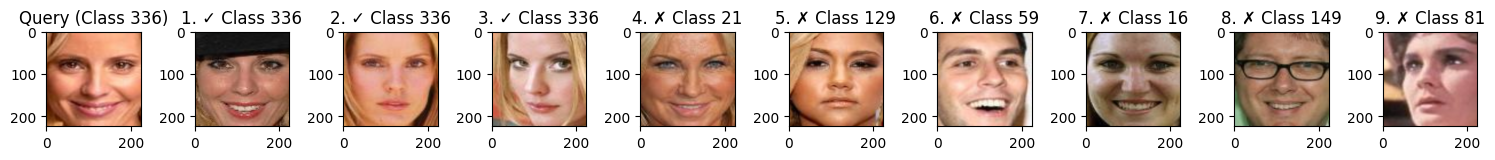

Точность в топ-3: 3/3 (100%)

Детали теста:
Query class: 336
Distances: [0.10867643356323242, 0.13079547882080078, 0.17078572511672974, 0.19621461629867554, 0.19858461618423462]

Выбран класс 450 с 4 изображениями
[[ 0  1  4 12  2  3 13  7  5  9 10  8 11  6]]
[ 0  1  4 12  2  3 13  7  5  9 10  8 11  6]
14 0


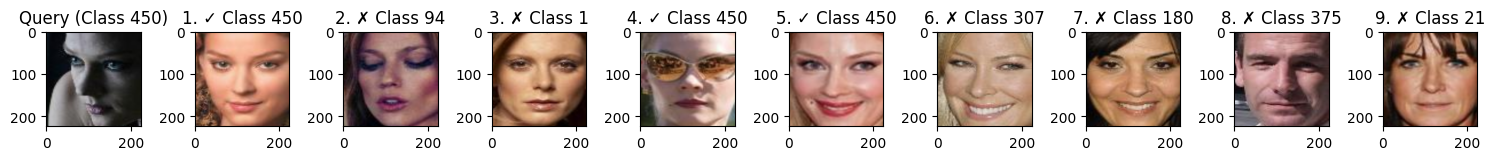

Точность в топ-3: 1/3 (33%)

Детали теста:
Query class: 450
Distances: [0.18661260604858398, 0.18937373161315918, 0.19980984926223755, 0.2065192461013794, 0.2721635103225708]

Выбран класс 409 с 4 изображениями
[[ 0  1 10  2  3  5  6 13 11  8  7 12  4  9]]
[ 0  1 10  2  3  5  6 13 11  8  7 12  4  9]
14 0


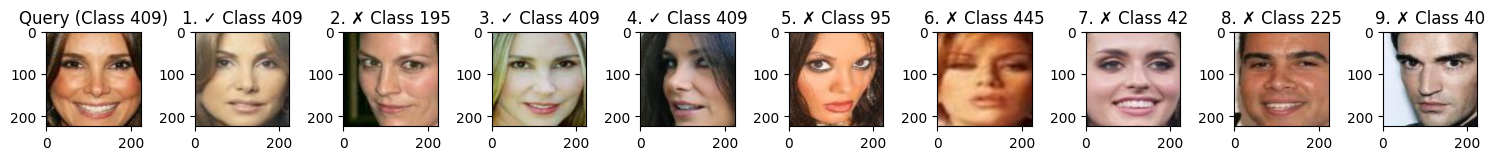

Точность в топ-3: 2/3 (67%)

Детали теста:
Query class: 409
Distances: [0.10372614860534668, 0.15439754724502563, 0.16798049211502075, 0.22927111387252808, 0.24572211503982544]

Выбран класс 321 с 4 изображениями
[[ 0  1  3  7  2  4  5 11  8  6 12 10 13  9]]
[ 0  1  3  7  2  4  5 11  8  6 12 10 13  9]
14 0


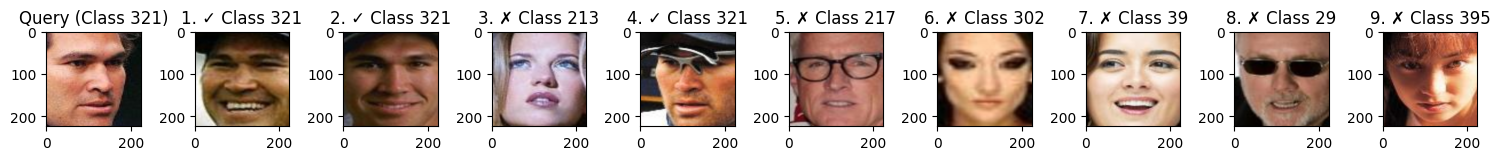

Точность в топ-3: 2/3 (67%)

Детали теста:
Query class: 321
Distances: [0.20009106397628784, 0.2125987410545349, 0.2426188588142395, 0.25364458560943604, 0.25747358798980713]



In [29]:
for _ in range(5):
    results = test_model(loaded_model, test_loader, k_samples=3, k_others=10)
    print("\nДетали теста:")
    print(f"Query class: {results['query_class']}")
    print(f"Distances: {results['top5_distances']}\n")

Выбран класс 441 с 4 изображениями
[[ 0  3  2  9  7  4  5 10  6 11 12 13  1  8]]
[ 0  3  2  9  7  4  5 10  6 11 12 13  1  8]
14 0


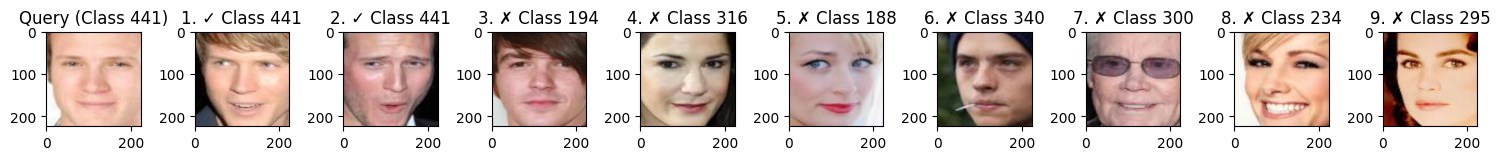

Точность в топ-3: 2/3 (67%)

Детали теста:
Query class: 441
Top-5 classes: [np.int64(441), np.int64(441), np.int64(194), np.int64(316), np.int64(188)]
Distances: [0.16692596673965454, 0.18475598096847534, 0.2128143310546875, 0.222670316696167, 0.2442702054977417]

Выбран класс 10 с 4 изображениями
[[ 0 12 10  8  1  3  2  4  5 13 11  9  7  6]]
[ 0 12 10  8  1  3  2  4  5 13 11  9  7  6]
14 0


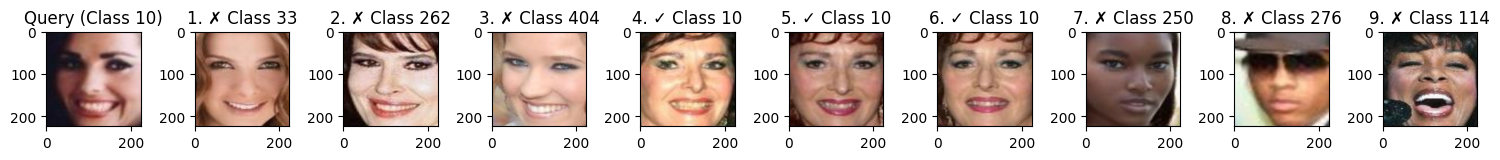

Точность в топ-3: 0/3 (0%)

Детали теста:
Query class: 10
Top-5 classes: [np.int64(33), np.int64(262), np.int64(404), np.int64(10), np.int64(10)]
Distances: [0.12262886762619019, 0.14504021406173706, 0.1523842215538025, 0.1646384596824646, 0.20355725288391113]

Выбран класс 214 с 4 изображениями
[[ 0  3  1  7  2 10  4  9 12 13  5  6 11  8]]
[ 0  3  1  7  2 10  4  9 12 13  5  6 11  8]
14 0


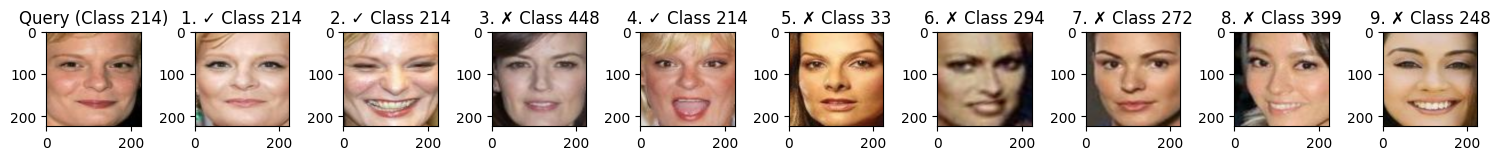

Точность в топ-3: 2/3 (67%)

Детали теста:
Query class: 214
Top-5 classes: [np.int64(214), np.int64(214), np.int64(448), np.int64(214), np.int64(33)]
Distances: [0.1130293607711792, 0.12199628353118896, 0.1551327109336853, 0.17169004678726196, 0.17840170860290527]

Выбран класс 457 с 5 изображениями
[[ 0  3  1  2  7 11  5 10  9 12 13  4  6  8]]
[ 0  3  1  2  7 11  5 10  9 12 13  4  6  8]
14 0


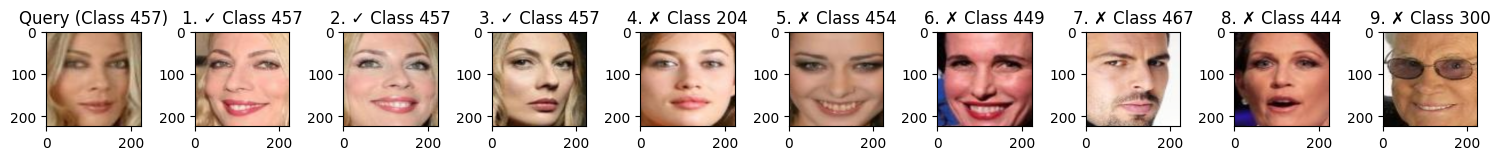

Точность в топ-3: 3/3 (100%)

Детали теста:
Query class: 457
Top-5 classes: [np.int64(457), np.int64(457), np.int64(457), np.int64(204), np.int64(454)]
Distances: [0.08899897336959839, 0.09671157598495483, 0.10505509376525879, 0.11799943447113037, 0.16779816150665283]

Выбран класс 417 с 5 изображениями
[[ 0  2  3  1  9  5  6 10 13 11  7  8  4 12]]
[ 0  2  3  1  9  5  6 10 13 11  7  8  4 12]
14 0


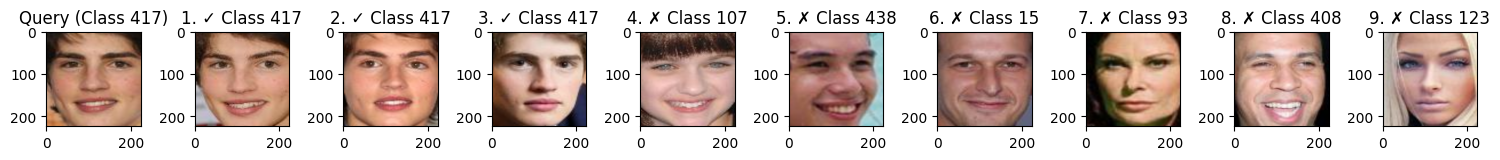

Точность в топ-3: 3/3 (100%)

Детали теста:
Query class: 417
Top-5 classes: [np.int64(417), np.int64(417), np.int64(417), np.int64(107), np.int64(438)]
Distances: [0.07414817810058594, 0.09329438209533691, 0.16075372695922852, 0.17129182815551758, 0.266071081161499]



In [30]:
for _ in range(5):
    results = test_model(loaded_model, val_loader, k_samples=3, k_others=10)
    print("\nДетали теста:")
    print(f"Query class: {results['query_class']}")
    print(f"Top-5 classes: {results['top5_classes']}")
    print(f"Distances: {results['top5_distances']}\n")

# **Воспользуемся также предобученной на лица моделью FaceNet:**

In [16]:
import torch
import numpy as np
from facenet_pytorch import InceptionResnetV1
from PIL import Image
from sklearn.neighbors import NearestNeighbors

facenet = InceptionResnetV1(pretrained='vggface2').eval().to(device)

class FaceNetOnly:
    def __init__(self, facenet):
        self.facenet = facenet
        self.mean = torch.tensor([0.5, 0.5, 0.5]).view(1,3,1,1).to(device)
        self.std = torch.tensor([0.5, 0.5, 0.5]).view(1,3,1,1).to(device)

    def get_embeddings(self, images):
        """Простая версия без детекции лиц"""
        with torch.no_grad():
            images = F.interpolate(images, size=160, mode='bilinear')
            images = (images - self.mean) / self.std

            return self.facenet(images).cpu().numpy()

facenet_only = FaceNetOnly(facenet)

In [17]:
from sklearn.neighbors import NearestNeighbors

def test_facenet_model(model, test_loader, num_classes=500, k_samples=5, k_others=10):
    all_embeddings = []
    all_labels = []
    all_images = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            embeddings = model.get_embeddings(images)
            all_embeddings.append(embeddings)
            all_labels.append(labels.numpy())
            all_images.append(images.cpu())

    all_embeddings = np.concatenate(all_embeddings)
    all_labels = np.concatenate(all_labels)
    all_images = torch.cat(all_images)

    unique_classes, class_counts = np.unique(all_labels, return_counts=True)

    valid_classes = unique_classes[class_counts >= (k_samples + 1)]

    if len(valid_classes) == 0:
        print(f"Ошибка: Нет классов с минимум {k_samples+1} изображениями")
        return

    test_class = np.random.choice(valid_classes)
    class_indices = np.where(all_labels == test_class)[0]
    other_indices = np.where(all_labels != test_class)[0]

    print(f"Выбран класс {test_class} с {len(class_indices)} изображениями")

    if len(other_indices) < k_others:
        print(f"Предупреждение: Только {len(other_indices)} изображений других классов (запрошено {k_others})")
        k_others = len(other_indices)

    np.random.shuffle(class_indices)
    query_idx = class_indices[0]
    positive_idxs = class_indices[1:k_samples+1]

    np.random.shuffle(other_indices)
    negative_idxs = other_indices[:k_others]

    test_idxs = np.concatenate([[query_idx], positive_idxs, negative_idxs])
    test_embeddings = all_embeddings[test_idxs]
    test_labels = all_labels[test_idxs]

    knn = NearestNeighbors(n_neighbors=len(test_idxs), metric='cosine')
    knn.fit(test_embeddings)
    distances, indices = knn.kneighbors([test_embeddings[0]])
    print(indices)
    print(indices[0])

    plot_results(all_images[test_idxs], test_labels, indices[0], indices[0][0], k_samples)

    return {
        'query_class': test_class,
        'query_idx': query_idx,
        'top5_classes': [test_labels[i] for i in indices[0][1:6]],
        'top5_distances': distances[0][1:6].tolist()
    }

def plot_results(images, labels, indices, query_idx, k_samples=5, num_to_plot = 10):
    plt.figure(figsize=(15, 5))
    k = k_samples + 1

    plt.subplot(1, num_to_plot, 1)
    print(len(images), query_idx)
    imshow(images[query_idx], f"Query (Class {labels[query_idx]})")

    for i, idx in enumerate(indices[1:num_to_plot]):
        plt.subplot(1, num_to_plot, i+2)
        match = "✓" if labels[idx] == labels[query_idx] else "✗"
        imshow(images[idx], f"{i+1}. {match} Class {labels[idx]}")

    plt.tight_layout()
    plt.show()

    correct = sum(labels[idx] == labels[query_idx] for idx in indices[1:k])
    print(f"Точность в топ-{k_samples}: {correct}/{k_samples} ({correct/k_samples:.0%})")

Выбран класс 415 с 5 изображениями
[[ 0  2  4  3 10 13 11 14 12  1  6  5  9  8  7]]
[ 0  2  4  3 10 13 11 14 12  1  6  5  9  8  7]
15 0


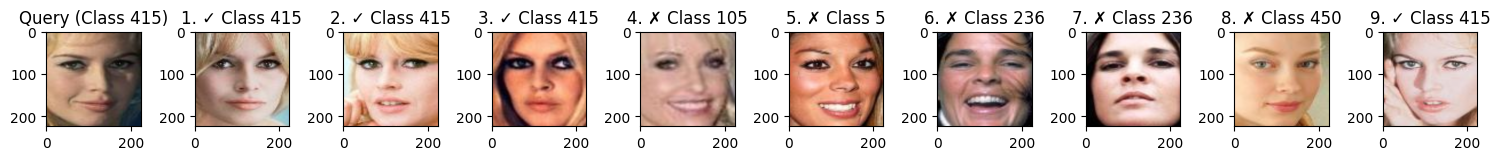

Точность в топ-4: 3/4 (75%)

Детали теста:
Query class: 415
Top-5 classes: [415, 415, 415, 105, 5]
Distances: [0.2732018232345581, 0.3566797971725464, 0.40001344680786133, 0.4083651304244995, 0.414436936378479]

Выбран класс 261 с 5 изображениями
[[ 0  1  4  3  2  8 12  6  7 14  5 11  9 13 10]]
[ 0  1  4  3  2  8 12  6  7 14  5 11  9 13 10]
15 0


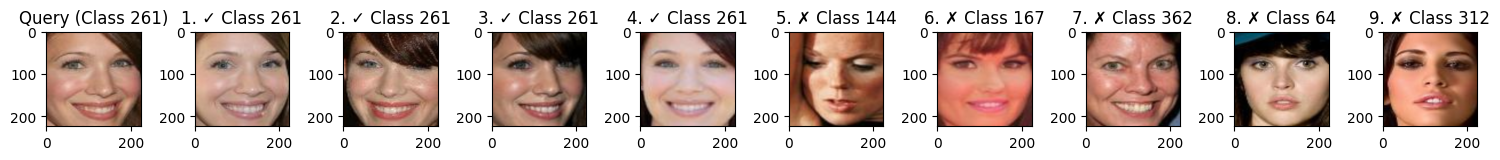

Точность в топ-4: 4/4 (100%)

Детали теста:
Query class: 261
Top-5 classes: [261, 261, 261, 261, 144]
Distances: [0.201851487159729, 0.40135401487350464, 0.4688832759857178, 0.49373364448547363, 0.5907986760139465]

Выбран класс 154 с 5 изображениями
[[ 0  3  2  7 13  4  6  1 12 14 11  9 10  8  5]]
[ 0  3  2  7 13  4  6  1 12 14 11  9 10  8  5]
15 0


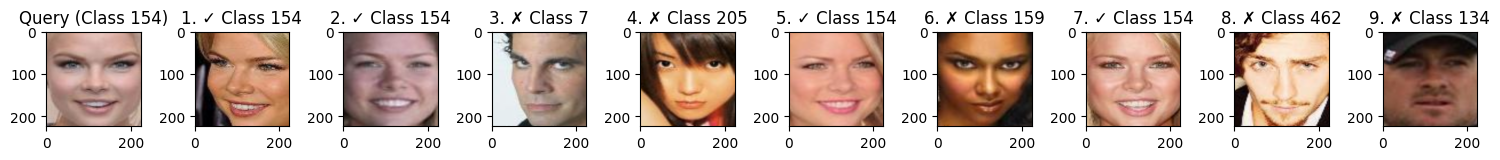

Точность в топ-4: 2/4 (50%)

Детали теста:
Query class: 154
Top-5 classes: [154, 154, 7, 205, 154]
Distances: [0.25900042057037354, 0.37616240978240967, 0.41867852210998535, 0.4773278832435608, 0.5913671851158142]

Выбран класс 102 с 5 изображениями
[[ 0  6  2  4 12 11  9 10  7  8  1  5  3 13 14]]
[ 0  6  2  4 12 11  9 10  7  8  1  5  3 13 14]
15 0


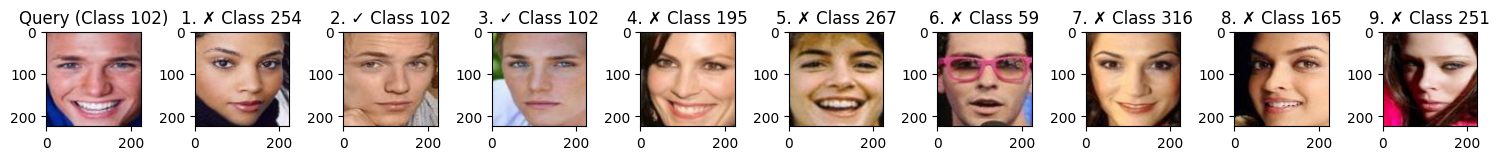

Точность в топ-4: 2/4 (50%)

Детали теста:
Query class: 102
Top-5 classes: [254, 102, 102, 195, 267]
Distances: [0.24057960510253906, 0.3067072033882141, 0.37547361850738525, 0.5586721301078796, 0.5607367753982544]

Выбран класс 427 с 5 изображениями
[[ 0  3  1 14  2  9  5 10 12  6 11  8  4 13  7]]
[ 0  3  1 14  2  9  5 10 12  6 11  8  4 13  7]
15 0


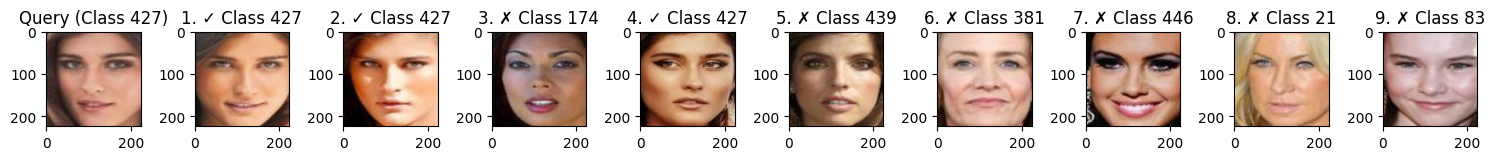

Точность в топ-4: 3/4 (75%)

Детали теста:
Query class: 427
Top-5 classes: [427, 427, 174, 427, 439]
Distances: [0.25913751125335693, 0.27429234981536865, 0.34492695331573486, 0.3593791723251343, 0.39893603324890137]



In [19]:
for _ in range(5):
    results = test_facenet_model(facenet_only, val_loader, k_samples=4, k_others=10)
    print("\nДетали теста:")
    print(f"Query class: {results['query_class']}")
    print(f"Top-5 classes: {results['top5_classes']}")
    print(f"Distances: {results['top5_distances']}\n")